# Intro to Digital Audio

To be able to work with audio signals in a computer, we need to create a series of discrete values from a continuous sound wave.

This notebook will walk you through the fundamentals of how audio is represented in Python, how to create a custom dataset of music using yt-dlp/musicdl, and how to visualize the waveform of an audio file.

<a href="https://colab.research.google.com/github/evanteal15/f25-shazam-clone-w1/blob/main/week1_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
import scipy

# What is a sound wave?


Sounds are produced via vibrations of air particles which form sound waves. Sounds waves have the same 3 defining characteristics as other waves: frequency (which is the measure of the number of vibrations per second measured in Hz), amplitude (measure of the intensity of the sound which is taken in terms of dB), and phase (the state that the wave cycle that the sound is in at a single point in time).


Sounds we hear, as shown in the waveform below, are produced by the combinations of waves of many different frequencies and amplitudes compounded together. Constructive and destructive interference influence how these waves interact with each other, increasing and decreasing the amplitude of each frequency accordingly. Understanding all of this process is not necessary but it is important to know that sound is a combination of many waves with varying loudness and pitch which come together in a way that humans can listen to and interpret.


<img src=asset/wave_comp.png width="500">


Speakers make sounds by pushing a cone up and down according to the data in an audio file. This produces vibrations in the air to produce the sound waves that make the same sound as what was recorded from the original sound.


For this reason, the main audio file formats of .mp3 and .wav files store an amplitude value amplitude at each time step. The "amplitude", usually measured in dB, again informs the position that the cone should be pushed to at any time with high values measuring moving the cones forward and low values meaning pulling the cone back in order to create the desired sound.


<img src=asset/file.png width="500">


Now that we know how audio is stored, how are we able to go from a sound to an audio file in the first place? Well this is informed by two measures:


- **sample rate** - number of samples per second (Hz). The sampling rate determines the time resolution of our representation.
    - The time in seconds between consecutive samples is $1/\mathrm{sr}$, called the sampling interval
- **bit depth** - The number of bits used to store each sample. The larger the bit depth, the more precision we have to store frequency information (frequency resolution).


The higher the sample rate and bit depth, the higher the resolution of audio we are able to play and record. A higher sample rate leads to more frequency measurements taken and a higher bit depth means that we have more possible frequencies (you can think of frequencies as notes for simplification) that the audio can take on when stored.


For the sake of this project we will be using wav files instead of mp3 files due to wav files being uncompressed. Compressed audio files (like mp3s) do not retain all sonic information from an original recording in order to save memory overhead making them good for streaming. However, this is not ideal for audio processing and recognition due to the normalization of the volume and reduction of very high and very low frequency sounds.


# Exercise

Let's play around with the frequency and sample rate to see what information we are able to gather from the generated wave.

The wave will be of the specified frequency and the dots are the samples taken from this wave for the given sample rate. 

Do you notice any relationship between sampling rate and frequency?

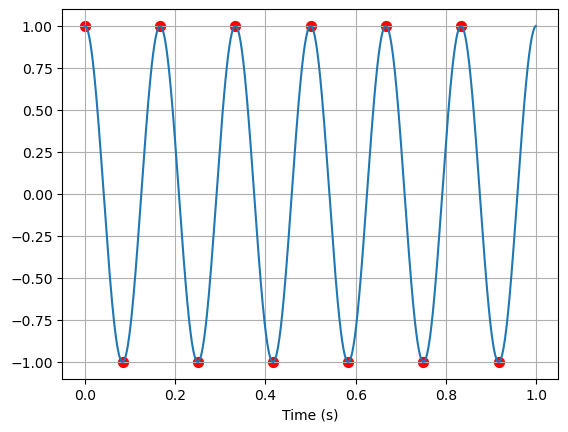

In [3]:
# frequency of the audio signal
freq_Hz = 6

# rate at which audio is being sampled
sample_rate_Hz = 12

x_source = np.linspace(0, 1, 1000, endpoint=False)
y_source = np.cos(freq_Hz * 2*np.pi*x_source)

x_samples = np.linspace(0, 1, sample_rate_Hz, endpoint=False)
y_samples = np.cos(freq_Hz * 2*np.pi*x_samples)

plt.plot(x_source, y_source)
plt.scatter(x_samples, y_samples, color="red", s=50)
plt.xlabel("Time (s)")
plt.grid()


## How many samples do we need?

The samples inside a wav file are used to reconstruct the original audio as a continuous waveform to be played back for listening.

**Nyquist-Shannon sampling theorem**: If a signal contains no frequencies higher than $f_\mathrm{max}$, then the signal can be perfectly reconstructed when sampled at a rate $sr > 2f_\mathrm{max}$. In other words, the maximum reconstructable frequency is strictly less than $sr/2$.


It is because of this theorem that you probably noticed that sampling rates twice that of the frequency are able to sample exactly at each peak and valley. This proves that in order to fully capture information about a wave of a given frequency and thus be able to reconstruct it during audio playback, we need to sample at twice that frequency.


If we do not have a high enough sampling rate we can run into the phenomenon of aliasing. When the sampling rate is not fast enough to accurately reconstruct the highest frequency waves in the waveform, which results in misrepresenting them as low frequencies. This is a big issue for shazam's algorithm since we need to be able to know the distribution of the frequencies of the original audio to make an accurate prediction.


**Question**: In order to cover the human hearing range of 20 Hz to 20 kHz, what is the minimum sampling rate required?

In [4]:
sampling_rate_required = 40

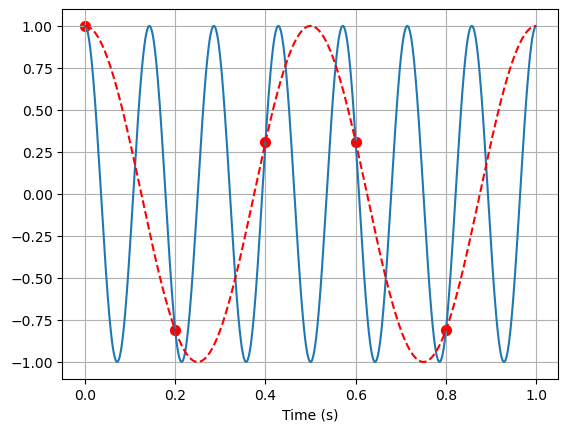

In [5]:
# TODO: set a sample rate to be able to reconstruct the original frequency
sample_rate_Hz = 5
freq_Hz = 7

# The Nyquist frequency is defined as sr/2
# Any sinusoid with freq > sr/2 has an alias with freq < sr/2
#     alias: sinusoid indistinguisable by sampling alone (same samples)
k: int = 1  # any integer
freq_alias_wave_Hz = np.abs(freq_Hz - k*sample_rate_Hz)

x_source = np.linspace(0, 1, 1000, endpoint=False)
y_source = np.cos(freq_Hz * 2*np.pi*x_source)

x_reconstructed = np.linspace(0, 1, 1000, endpoint=False)
y_reconstructed = np.cos(min(freq_alias_wave_Hz, freq_Hz) * 2*np.pi*x_reconstructed)

x_samples = np.linspace(0, 1, sample_rate_Hz, endpoint=False)
y_samples = np.cos(freq_Hz * 2*np.pi*x_samples)

plt.plot(x_source, y_source)
plt.plot(x_reconstructed, y_reconstructed, color="red", linestyle="--")
plt.scatter(x_samples, y_samples, color="red", s=50)
plt.xlabel("Time (s)")
plt.grid()


# Obtaining audio files

To create a database of songs that our Shazam clone will be able to recognize, we can use the [yt-dlp](https://github.com/yt-dlp/yt-dlp) Python package to download audio files directly from YouTube.

Find a music video from youtube and paste the url below to see if you can download and play it's audio.

In [12]:
import yt_dlp

# TODO: add any youtube video url here, copied from browser address bar
youtube_url = "https://youtu.be/Fp8msa5uYsc?si=SgTM3mpekKonj2b9"

# name of the output audio file the video will be stored in
yt_audio_path = "yt_sample.wav"

# downloading options
ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': "yt_sample.%(ext)s",  # output file
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',     # save as wav file
        }],
        #'cookiefile': 'cookies.txt',
    }

# download only if youtube_url is not empty
if youtube_url != "https://youtu.be/Fp8msa5uYsc?si=SgTM3mpekKonj2b9":
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([youtube_url])



## musicdl: helper script for downloading audio

For convienience, we've created a yt-dlp wrapper program that accepts urls from either YouTube or Spotify, and downloads the respective audio files to a specified folder.

Install the program below.

In [19]:
!git clone --depth 1 https://github.com/dennisfarmer/musicdl.git
%pip install -e ./musicdl
from musicdl.yt import YoutubeDownloader

fatal: destination path 'musicdl' already exists and is not an empty directory.
Obtaining file:///Users/yongyong7777/Documents/mdst/shazam-clone-f25/musicdl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for musicdl (pyproject.toml) ... done
  Created wheel for musicdl: filename=musicdl-2025.7-0.editable-py3-none-any.whl size=5845 sha256=8a39534178874d50aed532ac5388257b3ccd0e182070858c0b15258ab2e5bd67
  Stored in directory: /private/var/folders/8q/3bk4mhcd2l38k0_tbmtbbsv80000gn/T/pip-ephem-wheel-cache-3kgdl8xa/wheels/0a/1c/ba/95a71a3f0207bb1a83edc0549fdd5391b1732b1faeea237cac
Successfully built musicdl
  Attempting uninstall: musicdl
    Found existing installation: musicdl 2025.7
    Uninstalling musicdl-2025.7:
      Successfully uninstalled musicdl-2025.7
Note: you may need to restart the kernel to use up

ModuleNotFoundError: No module named 'musicdl.yt'

In [16]:
# run help to see information about the download function
help(YoutubeDownloader.download)

NameError: name 'YoutubeDownloader' is not defined

# Exercise

Use musicdl to download the audio of a YouTube video again like above.

In [13]:
from pprint import pprint

ydl = YoutubeDownloader(
    audio_directory="./tracks", 
    audio_format="wav"
)

# TODO: add any addition youtube video urls here that you want to download
youtube_urls = [
    "https://www.youtube.com/watch?v=TqxfdNm4gZQ"
]

# will download the audio files to ./tracks
tracks_info = ydl.download(youtube_urls)

# print information stores about the downloaded tracks
pprint(tracks_info)

# write to csv
tracks_csv = "./tracks/tracks_info.csv"
# ...

# read from csv
#with open(tracks_csv, "r") as f:
    #tracks_df = pd.read_csv(f)
    #tracks_list = list(tracks_df.to_dict(orient="records"))


NameError: name 'YoutubeDownloader' is not defined

# Working with audio data in Python:

## Visualizing the amplitude and sample rate of an audio file

[`librosa.load()` documentation](https://librosa.org/doc/0.11.0/generated/librosa.load.html#librosa.load)

In [ ]:
import librosa

#audio_path = yt_audio_path
audio_path = "sample.wav"
ipd.Audio(audio_path)

# Use librosa.load() to read file at audio_path
# default is to convert to mono (1 channel)
# audio, sr = ???
#print(f"sample rate = {sr} Hz")

#plt.figure(figsize=(12, 4))
#plt.plot(audio, lw=0.1)  # interpolated waveform
#plt.scatter(np.arange(len(audio)), audio, s=0.005, color="red")  # individual samples
#plt.title("Audio Waveform")
#plt.xlabel("Sample Index")
#plt.ylabel("Amplitude")
#plt.show()

#print("audio is digitally represented as a numpy.ndarray:")
#audio

As you can see from above, files are downloaded from ytp_dl with an ideal sampling rate of 48 kHZ (1 kHZ = 1,000 HZ) and can be converted into a nump array using librosa. Values in the librosa audio array represent the value amplitude at each time index which can be visualized in the waveform above.

## Downsampling

internally, downsampling (reducing the sample rate) performs the following process:
1. uses a low pass anti-aliasing filter to remove higher frequency components
    - low pass: keep signals with frequency lower than a specified cutoff frequency
2. keeps every nth sample using a sample step size of $(\mathrm{sr_{old}}/\mathrm{sr_{new}})$
    - the details of this process are not super important to know
    - if $(\mathrm{sr_{old}}/\mathrm{sr_{new}})$ is not an integer, first upsamples via interpolation, then downsamples with step size $\mathrm{sr_{old}}$.
    - upsampling: each original sample is separated by inserting $(\mathrm{sr_{new}}-1)$ zeros, then signal is interpolated with filter to smooth out discontinuities (replacing zeros)

**Question**: In the low pass filter step, what would the cutoff frequency be if we resampled to 11,025 Hz?

In [ ]:
# cutoff_frequency = ???

In [ ]:
# Resample from 48,000 Hz to 11,025 Hz
# use librosa.load()
sr = 11_025

# Question: how would you plot just the first 10 seconds of an audio file?

# YOUR CODE HERE


# Task for today:

Using our code examples above and resources from online (PLEADE DONT USE GEN AI (ChatGPT, Claude, etc)! If you have questions ask us or you will probably not learn anything from this project) complete the following tasks.

1) download the audio from any youtube video as a .wav file
2) downsample the file to 44.1 kHz
3) crop the audio to any 5 second segment
4) visualize the resulting waveform
5) (optional) do the same thing with some recorded audio with pyaudio (try to figure this out yourself with pyaudio documentation)

In [ ]:
# YOUR CODE HERE

---
# Next week: visualizing frequency using a spectrogram

In [ ]:
import IPython.display as ipd
audio_path = "asset/log_scale_perception.wav"
ipd.Audio(audio_path)

## Method 1: Librosa

In [ ]:
audio, sr = librosa.load(audio_path, sr=None) 

# parameters of the short-time Fourier transform:
# (algorithm that creates the spectrogram)
win_length = 2**11  # number of samples in each window
n_fft = win_length
hop_length = win_length // 4
window = scipy.signal.get_window("triang", Nx=win_length)

S = librosa.stft(audio, 
                       n_fft=n_fft, hop_length=hop_length, 
                       win_length=win_length, window=window)
S_magnitude = np.abs(S)  # |a+bi| = sqrt(a^2 + b^2)
S_db = librosa.amplitude_to_db(S_magnitude, ref=np.max)

im = plt.imshow(S_db, cmap="inferno", aspect="auto", origin="lower")
plt.colorbar(im, format="%+2.0f dB")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.show()

## Method 2: Scipy (what we'll use)

In [ ]:
audio, sr = librosa.load(audio_path, sr=None) 

# parameters of the short-time Fourier transform:
# (algorithm that creates the spectrogram)
nperseg = win_length = 2**11  # number of samples in each window
nfft = n_fft = win_length
hop_length = win_length // 4
window = scipy.signal.get_window("triang", Nx=win_length)

# scipy.signal.stft also uses the sample rate to output 
# frequency (in Hz) and time (in seconds) vectors,
# corresponding to the rows and columns of the stft matrix 
# in "s_scipy"
fs=sr 
noverlap = nperseg - hop_length

freq_scipy, time_scipy, s_scipy = scipy.signal.stft(
    audio, 
    fs=fs, window="hann", nfft=nfft, 
    nperseg=nperseg, noverlap=noverlap
)

print(f"freq vector shape: {freq_scipy.shape}")
print(f"time vector shape: {time_scipy.shape}")
print(f"stft matrix shape: {s_scipy.shape}")

s_scipy_db = librosa.amplitude_to_db(np.abs(s_scipy), ref=np.max)

im = plt.imshow(s_scipy_db, cmap="inferno", aspect="auto", origin="lower")
plt.colorbar(im, format="%+2.0f dB")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.show()

## Recording from Microphone

In [ ]:
import scipy.io.wavfile
import numpy as np
import pyaudio

def record_audio(n_seconds: int = 5) -> str:
    """
    records audio using computer microphone
    """
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 48000


    input("Press Enter to begin recording 🎤")
    print("🎤 Listening for music", end="\r")

    outfile = "microphone_sample.wav"

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

    frames = []
    for _ in range(0, int(RATE / CHUNK * n_seconds)):
        data = stream.read(CHUNK)
        frames.append(data)

    stream.stop_stream()
    stream.close()
    p.terminate()


    audio_np = np.frombuffer(b''.join(frames), dtype=np.int16)
    scipy.io.wavfile.write(outfile, RATE, audio_np)
    print(f"✅ Recording saved to {outfile}", end="\n")

    return outfile

audio_path = record_audio()

In [ ]:
audio_path = "microphone_sample.wav"

audio, sr = librosa.load(audio_path, sr=None) 
S_db = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
im = plt.imshow(S_db, cmap="inferno", aspect="auto", origin="lower")
plt.colorbar(im, format="%+2.0f dB")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.show()

---
**BONUS**: Add noise to an audio
- brownian noise: $x(n+1) = x(n) + w(n)$
- $w(n) \stackrel{\mathrm{iid}}{\sim} \mathrm{N(0,1)}$
- $\mathtt{np.random.normal(0, 1, size), np.cumsum()}$

Why might this be useful for a music recognition system?

In [ ]:
audio, sr = librosa.load(audio_path, sr=None) 
noise = np.zeros(audio.shape[0])

def peak_normalize(x):
    # Normalize the audio to be within the range [-1, 1]
    return x / np.max(np.abs(x))


# YOUR CODE HERE


# 16-bit integer: [-32768, 32767]
# (2**15 - 1) = 32767
audio_with_noise = (audio + noise*0.5)
scaled = np.int16(peak_normalize(audio_with_noise) * 32767)
scipy.io.wavfile.write('audio_with_noise.wav', sr, scaled)
ipd.Audio("audio_with_noise.wav")

# YOUR ANSWER HERE